References:

Logistic regression: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a

ROC curves: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

Controlling the threshold in Logistic Regression in Scikit Learn: https://stackoverflow.com/questions/28716241/controlling-the-threshold-in-logistic-regression-in-scikit-learn

sklearn.metrics.precision_recall_curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html


# Preprocessing

In [1]:
import pickle
import numpy as np
import pandas as pd
from scipy import interp
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib notebook


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [115]:
# Load and preprocess the KGE/curation dataset
with open('kge_dataset.pkl', 'rb') as f:
    kge_dataset = pickle.load(f)
kge_df = pd.DataFrame.from_records(kge_dataset)
kge_df = kge_df.fillna(0)
# Every column except agent names and stmt type should be int
dtype_dict = {col: 'int64' for col in kge_df.columns
              if col not in ('agA_name', 'stmt_type', 'agB_name')}
kge_df = kge_df.astype(dtype_dict)
kge_df.head()

,stmt_num,stmt_hash,agA_name,stmt_type,agB_name,correct,medscan,reach,sparser,rlimsp,trips,hprd,isi,biopax,bel,signor,trrust
0,0,28616404731074564,TGFB1,Activation,MAPK3,1,17,3,3,0,0,0,0,0,0,0,0
1,1,34133827417313284,TP53,IncreaseAmount,NKX2-1,0,0,6,0,0,0,0,0,0,0,0,0
2,2,2587683760588810,DACT2,Complex,CTNNB1,1,1,4,2,0,0,0,0,0,0,0,0
3,4,-20297417063899124,LRRK2,Phosphorylation,EIF4EBP1,1,1,11,13,10,0,0,0,0,0,0,0
4,5,-31679163966597107,IGF1,Activation,ERK,1,16,98,29,0,8,0,0,0,0,0,0


<IPython.core.display.Javascript object>


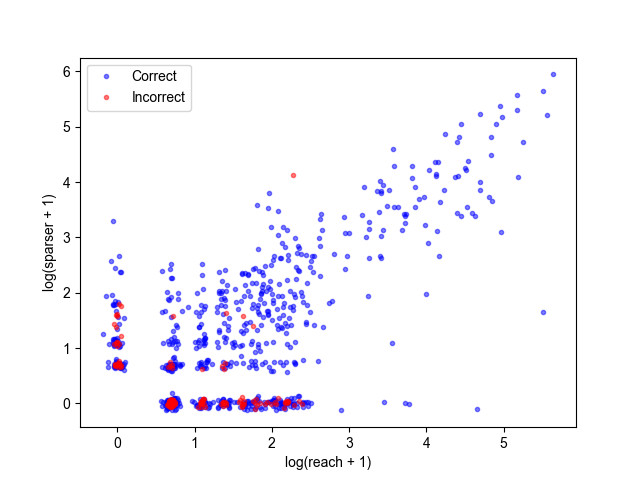

In [116]:
plt.figure()

def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev
reader1 = 'reach'
reader2 = 'sparser'

kge_cp = kge_df.copy()
kge_cp  = kge_cp[(kge_df[reader1] > 0) | (kge_df[reader2] > 0)]
kge_cp[reader1] = np.log(kge_df[reader1] + 1)
kge_cp[reader2] = np.log(kge_df[reader2] + 1)

kge_incorr = kge_cp[kge_cp['correct'] == 0]
kge_corr = kge_cp[kge_cp['correct'] == 1]

plt.plot(rand_jitter(kge_corr[reader1]),
         rand_jitter(kge_corr[reader2]), linestyle='', marker='.',
         color='blue', alpha=0.5, label='Correct')
plt.plot(rand_jitter(kge_incorr[reader1]),
         rand_jitter(kge_incorr[reader2]), linestyle='', marker='.',
                     color='red', alpha=0.5, label='Incorrect')
plt.xlabel(f'log({reader1} + 1)')
plt.ylabel(f'log({reader2} + 1)')
plt.legend(loc='upper left')

#logplot = sns.scatterplot(data=kge_cp, x='reach', y='sparser', hue='correct',
#                          x_jitter=100, y_jitter=100, alpha=0.5)
#logplot.set(xscale='log', yscale='log')

In [675]:
# Test for conditional independence
reader_s = 'sparser'
reader_r = 'reach'
p_s = kge_df[(kge_df[reader_s] > 0)]
p_r = kge_df[(kge_df[reader_r] > 0)]
pc_r_s = p_s[(p_s[reader_r] > 0) & (p_s['correct'] == 0)]
len(pc_r_s) / len(p_s)

0.0275049115913556

In [837]:
r1 = 'reach'
r2 = 'sparser'
rs_only_df = kge_df[(kge_df[r1] > 0) | (kge_df[r2] > 0)]
# Readers are same / 100% dependent
#rs_only_df['sparser'] = kge_df['reach']
# Readers are independent
#rs_only_df['sparser'] = rs_only_df['sparser'].sample(frac=1).values

#rs_only_df = kge_df
def prob(v, c=None, df=rs_only_df):
    """Probability of variables v: vals conditioned on variables c: vals"""
    if c is None:
        c = []
    if not v:
        raise ValueError("v variables must be specified")
    c_df = df
    for c_var in c:
        c_df = c_df[c_df[c_var] > 0]
    vc_df = None
    for v_var in v:
        if vc_df is None:
            vc_df = c_df[c_df[v_var] > 0]
        else:
            vc_df = vc_df[vc_df[v_var] > 0]
    return len(vc_df) / len(c_df)

In [838]:
# Both readers > 0
df = rs_only_df
print(r1, "only", len(df[(df[r1] > 0) & (df[r2] == 0)]))
print(r2, "only", len(df[(df[r2] > 0) & (df[r1] == 0)]))
print(r1, "and", r2, len(df[(df[r2] > 0) & (df[r1] > 0)]))
print("total", len(df))



reach only 296
sparser only 95
reach and sparser 414
total 805


In [839]:
# 1. The joint event
prob(['correct', r1, r2])

0.4968944099378882

In [840]:
# 2. By chain rule (exact vs above)
prob([r1]) * prob(['correct'], [r1]) * prob([r2], ['correct', r1])

0.49689440993788814

In [841]:
# 3. What we want to know: p(c|r,s) (exact)
prob(['correct'], [r1, r2])

0.966183574879227

In [842]:
# 4. What we want to know, by defn of cond prob vs. above (exact)
prob(['correct', r1, r2]) / prob([r1, r2]) #

0.9661835748792271

In [843]:
# 5 Applying chain rule (combining 2 and 4)
((prob([r1]) * prob(['correct'], [r1]) * prob([r2], ['correct', r1])) / 
     prob([r1, r2]))

0.966183574879227

In [844]:
# 6. Applying Bayes rule for p(r2|c,r1)
((prob([r1]) * prob(['correct'], [r1]) * prob(['correct', r1], [r2]) * prob([r2])) / 
     (prob([r1, r2])*prob(['correct'], [r1])*prob([r1])))

0.9661835748792269

In [845]:
# 7. Cancel terms
# p(c,r1|r2) * p(r2)
# ------------------
#      p(r1,r2)
(prob(['correct', r1], [r2]) * prob([r2])) / (prob([r1, r2]))

0.966183574879227

In [854]:
# 8. Substituting approximation: p(c,r1|r2) = p(c|r2)*p(r1|r2)
# p(c|r2) * p(r1|r2) * p(r2)
# --------------------------
#      p(r1,r2)
(prob(['correct'], [r2]) * prob([r1], [r2]) * prob([r2])) / (prob([r1, r2]))

# Full independence:
# p(c|r2) * p(r1) * p(r2)
# -------------------------- = p(c|r2)
#      p(r1) * p(r2)

# Full dependence:
# p(c|r2) * 1 * p(r2)
# --------------------------
#      p(r1,r2)


#((prob([r1]) * prob(['correct'], [r1]) * prob([r1], [r2]) * prob([r2])) / 
#     (prob([r1, r2])*prob(['correct'], [r1])*prob([r1])))

0.9174852652259332

In [847]:
prob(['correct'], [r2])

0.9174852652259332

In [848]:
# An expression that we need.
# If only one reader, all rows will have at least one evidence from that reader, whether correct or not
prob([r1, r2], ['correct'])

0.5997001499250375

In [849]:
# Approximation of above - if readers are the same, this should be quite wrong; if independent, quite right
prob([r1], ['correct']) * prob([r2], ['correct'])

0.6298200225224719

In [850]:
prob([r1], ['correct'])

0.8995502248875562

In [851]:
# Bayes rule vs p(r1,r2|c) - exact
(prob(['correct'], [r1, r2]) * prob([r1, r2])) / prob(['correct'])

0.5997001499250374

In [852]:
# Rearrange from above - exact
(prob([r1, r2], ['correct']) * prob(['correct'])) / prob([r1, r2])

0.9661835748792272

In [630]:
# Now, apply our assumption that p(r,s|c) ~= p(r|c)p(s|c)
# A hint in the fact that effectiveness of this changes when we filter dataset to statements with at least
# one of the two readers
(prob([r1], ['correct']) * prob([r2], ['correct']) * prob(['correct'])) / prob([r1, r2])

0.7601832886373714

In [631]:
prob(['correct'])

0.8285714285714286

In [600]:
kge_df.columns

Index(['stmt_num', 'stmt_hash', 'agA_name', 'stmt_type', 'agB_name', 'correct',
       'medscan', 'reach', 'sparser', 'rlimsp', 'trips', 'hprd', 'isi',
       'biopax', 'bel', 'signor', 'trrust'],
      dtype='object')

<IPython.core.display.Javascript object>


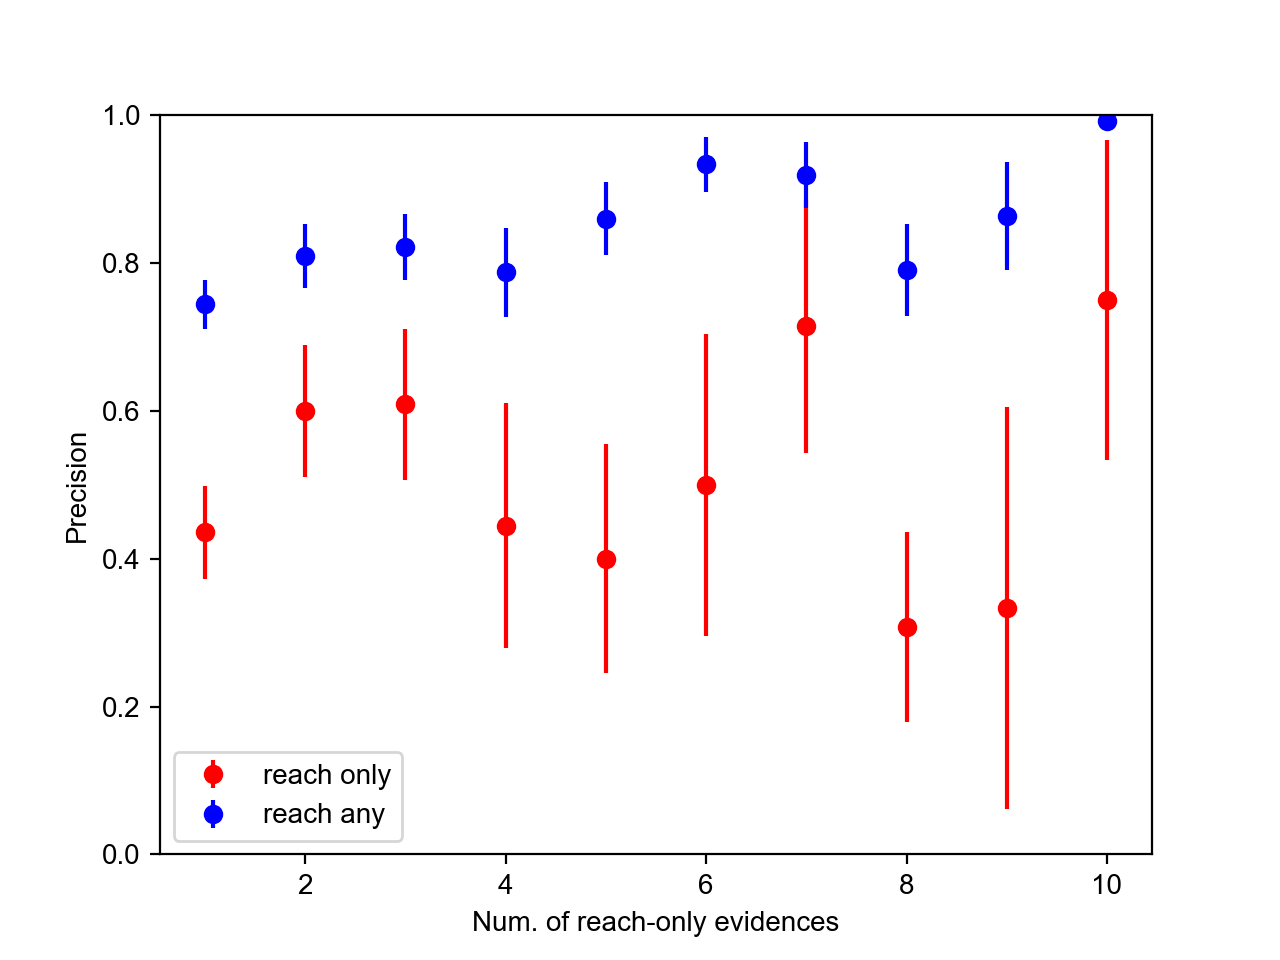

[]


In [113]:
source_cols = ['medscan', 'reach', 'sparser', 'rlimsp', 'trips', 'hprd', 'isi',
               'biopax', 'bel', 'signor', 'trrust']
reader = 'reach'
source_cols.pop(source_cols.index(reader))
# Reader only dataframe
ro_df = kge_df[~kge_df[source_cols].any(axis=1)]
x = list(range(1, 11))
r_only = []
r_all = []
r_only_cts = []
r_all_cts = []

def stderrp(p, n):
    pa = np.array(p)
    na = np.array(n)
    return(np.sqrt((pa*(1-pa))/na))

for i in x:
    lb = i
    if i < 10:
        ub = i+1
    else:
        ub = 10000
        
    r_only_rows = ro_df[(ro_df[reader] >= lb) & (ro_df[reader] < ub)]
    r_only.append(r_only_rows['correct'].mean())
    r_only_cts.append(len(r_only_rows['correct']))
    r_all_rows = kge_df[(kge_df[reader] >= lb) & (kge_df[reader] < ub)]
    r_all.append(r_all_rows['correct'].mean())
    r_all_cts.append(len(r_all_rows['correct']))
    
plt.figure()
plt.errorbar(x, r_only, linestyle='', yerr=stderrp(r_only, r_only_cts), marker='o', color='r', label=f'{reader} only')
plt.errorbar(x, r_all, linestyle='', yerr=stderrp(r_all, r_all_cts), marker='o', color='b', label=f'{reader} any')
plt.legend(loc='lower left')
plt.ylabel('Precision')
plt.xlabel(f'Num. of {reader}-only evidences')
plt.ylim([0, 1])
print(list(zip(x, counts)))

In [92]:
x

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [93]:
y

[0.15384615384615385, 0.25, 0.0, 0.0, 0.5, nan, nan, nan, nan, 1.0]

In [3]:
# Load previous curation dataset and the KGE scores
with open('curation_dataset.pkl', 'rb') as f:
    data_dict = pickle.load(f)

kge_df_scores = pd.read_csv('kge_dataset_w_scores.csv', index_col=0)
kge_df_scores.head()

,subject,relation,object,correct,score
0,TP53,IncreaseAmount,NKX2-1,0,-7.389051
1,DACT2,Complex,CTNNB1,1,-8.082224
2,LRRK2,Phosphorylation,EIF4EBP1,1,-7.293999
3,TSC2,Complex,CDK1,1,-7.195977
4,BCAS2,DecreaseAmount,TP53,1,-7.502889


In [4]:
# Prepare the scores data for the join
kds = kge_df_scores
kds = kds.rename(columns={'subject': 'agA_name', 'object': 'agB_name', 'relation': 'stmt_type'})
kds = kds.set_index([kds.agA_name, kds.stmt_type, kds.agB_name, kds.correct])
kds.head()

,,,,agA_name,stmt_type,agB_name,correct,score
agA_name,stmt_type,agB_name,correct,,,,,
TP53,IncreaseAmount,NKX2-1,0,TP53,IncreaseAmount,NKX2-1,0,-7.389051
DACT2,Complex,CTNNB1,1,DACT2,Complex,CTNNB1,1,-8.082224
LRRK2,Phosphorylation,EIF4EBP1,1,LRRK2,Phosphorylation,EIF4EBP1,1,-7.293999
TSC2,Complex,CDK1,1,TSC2,Complex,CDK1,1,-7.195977
BCAS2,DecreaseAmount,TP53,1,BCAS2,DecreaseAmount,TP53,1,-7.502889


In [5]:
# Set the multiindex on the main dataframe and do the join
kge_join = kge_df.set_index([kge_df.agA_name, kge_df.stmt_type, kge_df.agB_name, kge_df.correct]).join(kds, rsuffix='sc')
kge_join = kge_join.set_index(kge_join.stmt_num)
kge_join = kge_join.drop(columns=['agA_namesc', 'stmt_typesc', 'agB_namesc', 'correctsc'])
kge_join = kge_join[~pd.isna(kge_join.score)] # Keep only the rows with KGE scores
kge_join.head()

,stmt_num,stmt_hash,agA_name,stmt_type,agB_name,correct,medscan,reach,sparser,rlimsp,trips,hprd,isi,biopax,bel,signor,trrust,score
stmt_num,,,,,,,,,,,,,,,,,,
425,425,35492552341195618,ABL1,Phosphorylation,BCAR1,1,1,4,4,2,0,0,0,0,0,0,0,-6.827783
525,525,17253596610577440,ABL1,Phosphorylation,DGCR8,1,0,0,0,1,0,0,0,0,0,0,0,-7.676037
704,704,35535328953779602,ABL1,Phosphorylation,ENAH,1,0,1,0,2,0,0,0,0,0,0,0,-7.470222
567,567,31602217128375424,ABL1,Phosphorylation,PRKCD,1,2,1,1,3,0,0,0,0,0,0,0,-6.561732
986,986,34962009800728561,ABL1,Phosphorylation,SORBS1,1,0,0,4,2,0,0,0,0,0,0,0,-7.506958


In [6]:
# Old version: Load the data from curation_dataset dictionary
# df = pd.DataFrame.from_dict(data_dict)
# Preprocessing: replace missing values with 0s and encode stmt type as int
# df = df.fillna(0).sample(frac=1)

# New version: drop irrelevant columns
df = kge_join.drop(columns=['stmt_hash', 'stmt_num', 'agA_name', 'agB_name'])
le = LabelEncoder()
le.fit(df.stmt_type)
df.stmt_type = le.transform(df.stmt_type)
df.head()
x_df = df.drop('correct', axis=1)
x = x_df.values
y = df.correct.values
test_split = 0.2
test_size = int(len(y) * test_split)

In [7]:
test_size

102

# Train Models

In [21]:
num_folds = 10
models = {
    'Logistic Regression': LogisticRegression(),
    #'Random Forest Classifier': RandomForestClassifier(),
}
predictors = {'All features': x,
              'Without KGE': x[:, :-1], # Drop the score column
              'Only KGE': x[:, -1:]} # Only the score column

clf_results = {}
roc_results = {}
roc_aucs= {}
# For each model...
base_fpr = np.linspace(0, 1, 101)
for clf_name, clf in models.items():
    # Try different predictors...
    for pred_name, pred_x in predictors.items():
        # Fold the data multiple times
        # Save the data in a matrix (num_folds, test_size)
        tpr_arr = np.zeros((num_folds, len(base_fpr)))
        roc_auc_arr = np.zeros(num_folds)
        for fold_ix in range(num_folds):
            # Split the data
            x_train, x_test, y_train, y_test = train_test_split(pred_x, y, test_size=test_size)
            print(clf_name, pred_name, x_train.shape)
            # Train the model
            clf.fit(x_train, y_train)
            # Save the data
            clf_result = {}
            clf_result['y_preds'] = clf.predict(x_test)
            clf_result['y_probs'] = clf.predict_proba(x_test)
            #clf_results[clf_name] = clf_result
            
            # Compute ROC curve and ROC area for each class
            #roc_results = {}
            fpr, tpr, thresholds = roc_curve(y_test, clf_result['y_probs'][:, 1])
            roc_auc = auc(fpr, tpr)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tpr_arr[fold_ix, :] = tpr
            roc_auc_arr[fold_ix] = roc_auc
            #roc_result = {}
            #roc_result['fpr'] = fpr
            #roc_result['tpr'] = tpr
            #roc_result['roc_auc'] = roc_auc
            #roc_results[clf_name] = roc_result
        model_key = '%s %s' % (clf_name, pred_name)
        roc_results[model_key] = tpr_arr.mean(axis=0)
        roc_aucs[model_key] = roc_auc_arr

Logistic Regression All features (412, 13)
Logistic Regression All features (412, 13)
Logistic Regression All features (412, 13)
Logistic Regression All features (412, 13)
Logistic Regression All features (412, 13)
Logistic Regression All features (412, 13)
Logistic Regression All features (412, 13)
Logistic Regression All features (412, 13)
Logistic Regression All features (412, 13)
Logistic Regression All features (412, 13)
Logistic Regression Without KGE (412, 12)
Logistic Regression Without KGE (412, 12)
Logistic Regression Without KGE (412, 12)
Logistic Regression Without KGE (412, 12)
Logistic Regression Without KGE (412, 12)
Logistic Regression Without KGE (412, 12)
Logistic Regression Without KGE (412, 12)
Logistic Regression Without KGE (412, 12)
Logistic Regression Without KGE (412, 12)
Logistic Regression Without KGE (412, 12)
Logistic Regression Only KGE (412, 1)
Logistic Regression Only KGE (412, 1)
Logistic Regression Only KGE (412, 1)
Logistic Regression Only KGE (412, 1

In [22]:
# Correctness prediction for a single Sparser evidence
#sparser_ex = np.array([[0, 0, 1,0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
#models['Logistic Regression'].predict_proba(sparser_ex)
#models['Random Forest Classifier'].predict_proba(sparser_ex)

# ROC Curves

In [23]:
# Compute micro-average ROC curve and ROC area
#fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
#roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [24]:
#with open('belief_fpr_tpr_auc.pkl', 'rb') as f:
#    bel_fpr, bel_tpr, bel_roc_auc = pickle.load(f)


<IPython.core.display.Javascript object>


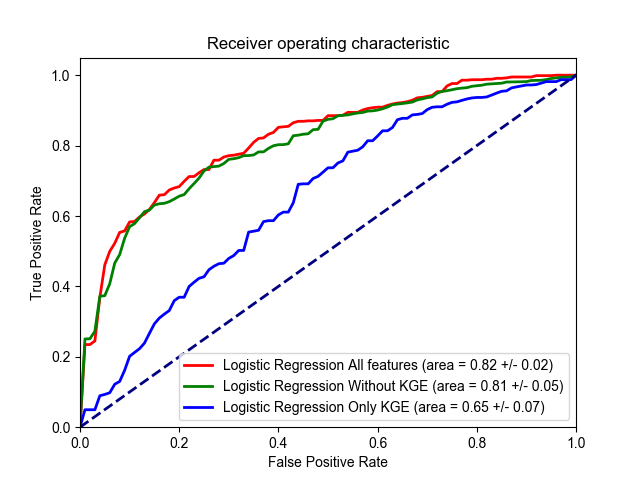

In [25]:
plt.figure()
lw = 2
colors = ['r', 'g', 'b', 'orange', 'k', 'y']

# Plot ROC curve for Belief Model (REACH)
#plt.plot(bel_fpr, bel_tpr, color=colors[0],
#         lw=lw, label='Orig. Belief (area = %0.2f)' % bel_roc_auc)
for i, (clf_name, roc_result) in enumerate(roc_results.items()):
    #fpr = roc_result['fpr']
    #tpr = roc_result['tpr']
    roc_auc_arr = roc_aucs[clf_name]
    plt.plot(base_fpr, roc_result, color=colors[i],
         lw=lw, label='%s (area = %0.2f +/- %0.2f)' %
                      (clf_name, roc_auc_arr.mean(), roc_auc_arr.std()))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('bel_roc.pdf')
plt.show()


In [ ]:
print(classification_report(y_test, y_preds, labels=[0, 1]))

In [ ]:
with open('belief_prec_rec_thresh_auc.pkl', 'rb') as f:
    bel_prec, bel_rec, bel_thresh, bel_pr_auc = pickle.load(f)


In [ ]:
pr_results = {}
for clf_name, clf_result in clf_results.items():
    precision, recall, thresholds = precision_recall_curve(y_test, clf_result['y_probs'][:, 1])
    pr_auc = metrics.auc(recall, precision)
    pr_results[clf_name] = {'precision': precision, 'recall': recall,
                            'thresholds': thresholds, 'pr_auc': pr_auc}

"""
plt.figure()
plt.plot(bel_thresh, bel_prec[: -1], color=colors[0],
             linestyle='-', label="Orig. Belief Precision (area = %0.2f)" % bel_pr_auc)
plt.plot(bel_thresh, bel_rec[: -1], color=colors[0],
             linestyle='--', label="Orig. Belief Recall")
""" 

for i, (clf_name, pr_result) in list(enumerate(pr_results.items()))[0:1]:
    plt.plot(pr_result['thresholds'], pr_result['precision'][: -1], color=colors[i],
             linestyle='-', label="%s Precision (area = %0.2f)" % (clf_name, pr_result['pr_auc']))
    plt.plot(pr_result['thresholds'], pr_result['recall'][: -1], color=colors[i+1],
             linestyle='--', label="%s Recall" % clf_name)
    
plt.title("Precision-Recall vs Threshold Chart")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])
plt.savefig('prec_rec.pdf')
plt.show()

In [ ]:
# Associate precision values for the statements at each threshold
# So, if a statement has probability value, check if it is above the threshold, and if so,
# assign it that precision.
list(zip(thresholds, precision))

In [ ]:
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# Logistic Regression

In [ ]:
logisticRegr.coef_

In [ ]:
sorted(list(zip(x_df.columns, logisticRegr.coef_[0])), key=lambda x: x[1], reverse=True)